## Double power law computation and plotting

In [318]:
import numpy as np
from scipy.optimize import curve_fit

def dbpl_sharp(x, A, a1, a2, a3, tb1, dlog):
    # Sharp (piecewise) double-broken power law with continuity at tb1 and tb2
    # tb2 is constrained > tb1 via dlog > 0
    x = np.asarray(x, dtype=float)
    tb2 = tb1 * np.exp(dlog)

    y = np.empty_like(x, dtype=float)

    m0 = x <= tb1
    m1 = (x > tb1) & (x < tb2)
    m2 = x >= tb2

    # Region 1: slope a1
    y[m0] = A * (x[m0] / tb1)**(-a1)

    # Region 2: slope a2, continuous at tb1 -> y(tb1) = A
    y[m1] = A * (x[m1] / tb1)**(-a2)

    # Region 3: slope a3, continuous at tb2
    y[m2] = A * (tb2 / tb1)**(-a2) * (x[m2] / tb2)**(-a3)

    return y

def _linear_slope(logx, logy):
    M = np.vstack([logx, np.ones_like(logx)]).T
    m, c = np.linalg.lstsq(M, logy, rcond=None)[0]
    return m

def _auto_guess_dbpl(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    xg, yg = x[mask], y[mask]
    order = np.argsort(xg)
    xg, yg = xg[order], yg[order]

    n = len(xg)
    if n < 10:
        raise ValueError("Need at least ~10 valid points for initial guess.")

    tb1 = np.percentile(xg, 30.0)
    tb2 = np.percentile(xg, 90.0)
    dlog = np.log(tb2 / tb1)

    i1 = max(3, int(0.25 * n))
    i2 = min(n - 3, int(0.75 * n))
    lx, ly = np.log10(xg), np.log10(yg)
    m1 = _linear_slope(lx[:i1], ly[:i1])
    m2 = _linear_slope(lx[i1:i2], ly[i1:i2])
    m3 = _linear_slope(lx[i2:], ly[i2:])
    a1, a2, a3 = -m1, -m2, -m3

    A_guess = np.median(yg[(xg > 0.8 * tb1) & (xg < 1.2 * tb1)]) if np.any((xg > 0.8 * tb1) & (xg < 1.2 * tb1)) else np.median(yg)

    return float(A_guess), float(a1), float(a2), float(a3), float(tb1), float(dlog)

def fit_dbpl_sharp(x, y, yerr=None, p0=None, maxfev=20000):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    if yerr is not None:
        yerr = np.asarray(yerr, float)

    if p0 is None:
        p0 = _auto_guess_dbpl(x, y)

    xmin_pos = np.nanmin(x[x > 0])
    xmax_pos = np.nanmax(x[x > 0])

    # Bounds: positive A, reasonable slopes, positive tb1, enforce tb2>tb1 via dlog>0
    lower = [max(1e-30, np.nanmin(y[y > 0]) * 1e-6 if np.any(y > 0) else 1e-30),
             -10.0, -10.0, -10.0,
             xmin_pos/10.0,
             np.log(1.1)]
    upper = [max(1e-30, np.nanmax(np.abs(y)) * 1e6),
             10.0, 10.0, 10.0,
             xmax_pos*10.0,
             np.log(1e6)]

    popt, pcov = curve_fit(
        dbpl_sharp, x, y,
        p0=p0,
        sigma=yerr if yerr is not None else None,
        absolute_sigma=yerr is not None,
        bounds=(lower, upper),
        maxfev=maxfev,
        method="trf"
    )

    perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else np.full_like(popt, np.nan)
    A, a1, a2, a3, tb1, dlog = popt
    tb2 = tb1 * np.exp(dlog)

    result = {
        "A": A, "a1": a1, "a2": a2, "a3": a3,
        "tb1": tb1, "tb2": tb2, "dlog": dlog,
        "A_err": perr[0], "a1_err": perr[1], "a2_err": perr[2], "a3_err": perr[3],
        "tb1_err": perr[4], "dlog_err": perr[5],
    }
    return result, popt, pcov

def pick_pos(xmin, xmax, frac=0.5):
    if (xmin > 0) and (xmax > 0):
        return np.exp(np.log(xmin) * (1 - frac) + np.log(xmax) * frac)
    return xmin + frac * (xmax - xmin)


## Single power law computation and plotting

In [319]:
def sbpl_sharp(x, A, a1, a2, tb):
    """
    Single sharp break power law function.
    
    Parameters:
    -----------
    x : array-like
        Time values
    A : float
        Amplitude at break time
    a1 : float
        Power law index before break (x <= tb)
    a2 : float
        Power law index after break (x > tb)
    tb : float
        Break time
        
    Returns:
    --------
    y : array
        Flux values
    """
    x = np.asarray(x, dtype=float)
    y = np.empty_like(x, dtype=float)
    
    # Before break: slope a1
    mask_before = x <= tb
    y[mask_before] = A * (x[mask_before] / tb)**(-a1)
    
    # After break: slope a2, continuous at tb
    mask_after = x > tb
    y[mask_after] = A * (x[mask_after] / tb)**(-a2)
    
    return y

def _auto_guess_sbpl(x, y):
    """
    Automatic initial parameter guess for single broken power law.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    xg, yg = x[mask], y[mask]
    order = np.argsort(xg)
    xg, yg = xg[order], yg[order]
    
    n = len(xg)
    if n < 6:
        raise ValueError("Need at least ~6 valid points for initial guess.")
    
    # Break time at median
    tb = np.median(xg)
    
    # Split data around break and fit slopes
    i_mid = n // 2
    lx, ly = np.log10(xg), np.log10(yg)
    
    # Before break
    if i_mid > 2:
        m1 = _linear_slope(lx[:i_mid], ly[:i_mid])
        a1 = -m1
    else:
        a1 = 0.0
    
    # After break
    if i_mid < n - 2:
        m2 = _linear_slope(lx[i_mid:], ly[i_mid:])
        a2 = -m2
    else:
        a2 = 0.0
    
    # Amplitude at break time
    A_guess = np.median(yg[(xg > 0.8 * tb) & (xg < 1.2 * tb)]) if np.any((xg > 0.8 * tb) & (xg < 1.2 * tb)) else np.median(yg)
    
    return float(A_guess), float(a1), float(a2), float(tb)

def fit_sbpl_sharp(x, y, yerr=None, p0=None, maxfev=20000):
    """
    Fit single broken power law to data.
    
    Parameters:
    -----------
    x : array-like
        Time values
    y : array-like
        Flux values
    yerr : array-like, optional
        Flux errors
    p0 : tuple, optional
        Initial parameters (A, a1, a2, tb)
    maxfev : int
        Maximum function evaluations
        
    Returns:
    --------
    result : dict
        Fitted parameters and errors
    popt : array
        Optimal parameters
    pcov : array
        Covariance matrix
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    if yerr is not None:
        yerr = np.asarray(yerr, float)
    
    if p0 is None:
        p0 = _auto_guess_sbpl(x, y)
    
    xmin_pos = np.nanmin(x[x > 0])
    xmax_pos = np.nanmax(x[x > 0])
    
    # Bounds: positive A, reasonable slopes, positive tb
    lower = [max(1e-30, np.nanmin(y[y > 0]) * 1e-6 if np.any(y > 0) else 1e-30),
             -10.0, -10.0,
             xmin_pos/10.0]
    upper = [max(1e-30, np.nanmax(np.abs(y)) * 1e6),
             10.0, 10.0,
             xmax_pos*10.0]
    
    popt, pcov = curve_fit(
        sbpl_sharp, x, y,
        p0=p0,
        sigma=yerr if yerr is not None else None,
        absolute_sigma=yerr is not None,
        bounds=(lower, upper),
        maxfev=maxfev,
        method="trf"
    )
    
    perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else np.full_like(popt, np.nan)
    A, a1, a2, tb = popt
    
    result = {
        "A": A, "a1": a1, "a2": a2, "tb": tb,
        "A_err": perr[0], "a1_err": perr[1], "a2_err": perr[2], "tb_err": perr[3]
    }
    return result, popt, pcov

def plot_sbpl_fit_with_break(x, y, popt=None, result=None, yerr=None, 
                            save_fig_file=None, show=True, label=''):
    """
    Plot data and single broken power law fit with break line and slope annotations.
    
    Provide either `popt` (A, a1, a2, tb) or `result` dict with those keys.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    
    if result is not None:
        A = float(result["A"])
        a1 = float(result["a1"])
        a2 = float(result["a2"])
        tb = float(result["tb"])
    elif popt is not None:
        A, a1, a2, tb = [float(v) for v in popt]
    else:
        raise ValueError("Provide either popt or result containing parameters.")
    
    # setup the common style for plots
    initplot()
    # create two subplots - 1: main and 2: residuals
    fig, (ax_main, ax_res) = plt.subplots(2, 1, figsize=(6, 6), 
                                       gridspec_kw={'height_ratios': [3, 1]},
                                       sharex=True)

    if yerr is not None:
        ax_main.errorbar(x, y, yerr=yerr, fmt="o", ms=4, lw=1, color='C1', alpha=0.75, label="Observed "+label)
    else:
        ax_main.scatter(x, y, s=18, color='C1', alpha=0.75, label="Observed " + label)
    
    finite_x = x[np.isfinite(x)]
    finite_y = y[np.isfinite(y)]
    xmin = np.nanmin(finite_x) if finite_x.size else np.nan
    xmax = np.nanmax(finite_x) if finite_x.size else np.nan
    
    y_model = sbpl_sharp(x, A, a1, a2, tb)
    residuals = y - y_model
    print(f'residuals={residuals}')
        
    ymin = np.nanmin(y)
    x_fit = np.logspace(np.log10(xmin*0.8), np.log10(xmax*1.2), num=100, base=10)
    print(f'x_fit={x_fit[:5]}..')

    y_fit = sbpl_sharp(x_fit, A, a1, a2, tb)


    ax_main.plot(x_fit, y_fit, color='C0', lw=2, label="Broken power-law fit")
    
    # Break line
    ax_main.axvline(tb, color="C0", ls="solid", lw=0.75)
    ax_res.axvline(tb, color="C0", ls="solid", lw=0.75)
    ax_main.set_yscale('log')

    ax_main.text(tb*0.94, ymin*0.92, f"t={tb:.3f}d", color="C0", ha="center", va="bottom", fontsize=10, rotation=90)


    def pick_pos(xmin, xmax, frac=0.5):
        if xmin > 0 and xmax > 0:
            return np.exp(np.log(xmin) * (1 - frac) + np.log(xmax) * frac)
        return xmin + frac * (xmax - xmin)
    
    
    # Before break annotation (alpha_1)
    if np.any(x <= tb):
        x_before = pick_pos(np.nanmin(x[x <= tb]), min(tb, xmax), 0.6)
        y_before = sbpl_sharp(np.array([x_before]), A, a1, a2, tb)[0]
        #ax_main.text(x_before*(1.0+1.0/(a1**2)), y_before, rf"$\alpha_1={a1:.2f}$", 
        ax_main.text(x_before*(1+1/(2*a1)), y_before*(1+a1/5), rf"$\alpha_1={a1:.2f}$", 
                color="C0", ha="left", va="bottom", fontsize=10)
    
    # After break annotation (alpha_2)
    if np.any(x > tb):
        x_after = pick_pos(max(tb, xmin), xmax, 0.4)
        y_after = sbpl_sharp(np.array([x_after]), A, a1, a2, tb)[0]
        #ax_main.text(x_after*(1.0+1.0/(a2**2)), y_after, rf"$\alpha_2={a2:.2f}$", 
        #ax_main.text(x_after*1.2, y_after*1.2, rf"$\alpha_2={a2:.2f}$", 
        ax_main.text(x_after*(1+1/(2*a2)), y_after*(1+a2/5), rf"$\alpha_2={a2:.2f}$", 
                color='C0', ha="right", va="bottom", fontsize=10)

    ## plot the residuals
    ax_res.scatter(x, residuals, s=18, color='C1', alpha=0.75)
    ax_res.axhline(y=0, color='C0', linestyle='solid', lw=0.75)
    ax_res.set_ylabel('Residuals')
    ax_res.grid(True, which='major', ls='--', alpha=0.3)

    plt.xscale('log')
    ax_res.set_yscale('linear')
    plt.xlabel("Time since trigger (days)")
    ax_main.set_ylabel(r"Flux Density $F_\nu$ (mJy)", labelpad=10)
    ax_main.grid(True, which='both', ls='--', alpha=0.3)
    ax_main.legend(loc='upper right')

    ax_res.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.1g}'))
    ax_res.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0e}'))
    ax_res.tick_params(axis='x', labelrotation=0)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.tight_layout()

    if save_fig_file is not None:
        plt.savefig(
            save_fig_file,
            bbox_inches='tight', dpi=300
        )

    if show:
        plt.show()



## Pure single power law (no break)


In [320]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def spl(x, A, a):
    """
    Single power law: y = A * x^(-a)
    Parameters
    ----------
    x : array-like
    A : float
        Amplitude at x=1 in the same units as x
    a : float
        Power-law index
    """
    x = np.asarray(x, dtype=float)
    return A * np.power(x, -a)


def _auto_guess_spl(x, y):
    """Heuristic initial guess (A, a) for single power-law fit."""
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    xg, yg = x[mask], y[mask]
    order = np.argsort(xg)
    xg, yg = xg[order], yg[order]

    if len(xg) < 3:
        # Fallback conservative guess
        return float(np.nanmedian(yg) if np.any(np.isfinite(yg)) else 1.0), 1.0

    lx, ly = np.log10(xg), np.log10(yg)
    M = np.vstack([lx, np.ones_like(lx)]).T
    m, c = np.linalg.lstsq(M, ly, rcond=None)[0]
    a_guess = -m
    # Intercept at x=1 => log10 A = c
    A_guess = 10.0**c
    # Guardrails
    if not np.isfinite(A_guess) or A_guess <= 0:
        A_guess = np.nanmedian(yg) if np.any(np.isfinite(yg)) else 1.0
    if not np.isfinite(a_guess):
        a_guess = 1.0
    return float(A_guess), float(a_guess)


def fit_spl(x, y, yerr=None, p0=None, maxfev=20000):
    """
    Fit a single power law y = A * x^(-a) to the data.

    Returns (result_dict, popt, pcov) mirroring existing fit API.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    if yerr is not None:
        yerr = np.asarray(yerr, float)

    if p0 is None:
        p0 = _auto_guess_spl(x, y)

    xmin_pos = np.nanmin(x[x > 0])
    xmax_pos = np.nanmax(x[x > 0])

    lower = [max(1e-30, np.nanmin(y[y > 0]) * 1e-6 if np.any(y > 0) else 1e-30),
             -10.0]
    upper = [max(1e-30, np.nanmax(np.abs(y)) * 1e6),
             10.0]

    popt, pcov = curve_fit(
        spl, x, y,
        p0=p0,
        sigma=yerr if yerr is not None else None,
        absolute_sigma=yerr is not None,
        bounds=(lower, upper),
        maxfev=maxfev,
        method="trf"
    )

    perr = np.sqrt(np.diag(pcov)) if np.all(np.isfinite(pcov)) else np.full_like(popt, np.nan)
    A, a = [float(v) for v in popt]
    result = {"A": A, "a": a, "A_err": float(perr[0]), "a_err": float(perr[1])}
    return result, popt, pcov


def plot_spl_fit(x, y, popt=None, result=None, yerr=None,
                 save_fig_file=None, show=True, label=''):
    """
    Plot data and single power law fit with residuals, matching existing style.
    Provide either popt (A, a) or result dict with keys A, a.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    if result is not None:
        A = float(result["A"]) ; a = float(result["a"])
    elif popt is not None:
        A, a = [float(v) for v in popt]
    else:
        raise ValueError("Provide either popt or result containing parameters.")

    # Use same plotting setup as other routines
    initplot()

    fig, (ax_main, ax_res) = plt.subplots(2, 1, figsize=(6, 6),
                                           gridspec_kw={'height_ratios': [3, 1]},
                                           sharex=True)

    if yerr is not None:
        ax_main.errorbar(x, y, yerr=yerr, fmt="o", ms=4, lw=1, color='C1', alpha=0.75, label="Observed "+label)
    else:
        ax_main.scatter(x, y, s=18, color='C1', alpha=0.75, label="Observed "+label)

    finite_x = x[np.isfinite(x)]
    xmin = np.nanmin(finite_x) if finite_x.size else np.nan
    xmax = np.nanmax(finite_x) if finite_x.size else np.nan

    y_model = spl(x, A, a)
    residuals = y - y_model

    x_fit = np.logspace(np.log10(xmin*0.8), np.log10(xmax*1.2), num=100, base=10)
    y_fit = spl(x_fit, A, a)

    ax_main.plot(x_fit, y_fit, color='C0', lw=2, label="Single power-law fit")
    ax_main.set_yscale('log')

    # Add alpha annotation near the middle of range
    def pick_pos(xmin, xmax, frac=0.5):
        if (xmin > 0) and (xmax > 0):
            return np.exp(np.log(xmin) * (1 - frac) + np.log(xmax) * frac)
        return xmin + frac * (xmax - xmin)

    x_mid = pick_pos(xmin, xmax, 0.5)
    y_mid = spl(np.array([x_mid]), A, a)[0]
    ax_main.text(x_mid*1.1, y_mid*1.1, rf"$\alpha={a:.2f}$", color='C0', ha='left', va='bottom', fontsize=10)

    # Residuals
    ax_res.scatter(x, residuals, s=18, color='C1', alpha=0.75)
    ax_res.axhline(y=0, color='C0', linestyle='solid', lw=0.75)
    ax_res.set_ylabel('Residuals')
    ax_res.grid(True, which='major', ls='--', alpha=0.3)

    plt.xscale('log')
    ax_res.set_yscale('linear')
    plt.xlabel("Time since trigger (days)")
    ax_main.set_ylabel(r"Flux Density $F_\nu$ (mJy)", labelpad=10)
    ax_main.grid(True, which='both', ls='--', alpha=0.3)
    ax_main.legend(loc='upper right')

    ax_res.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f'{v:.1g}'))
    ax_res.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f'{v:.0e}'))
    ax_res.tick_params(axis='x', labelrotation=0)

    plt.subplots_adjust(wspace=0, hspace=0)

    if save_fig_file is not None:
        plt.savefig(save_fig_file, bbox_inches='tight', dpi=300)

    if show:
        plt.show()


## Common plot style setup

In [321]:
from matplotlib import rcParams
def initplot():

    rcParams["font.size"] = 10
    rcParams["axes.linewidth"] = 1.0

    rcParams["xtick.direction"] = "in"
    rcParams["ytick.direction"] = "in"
    rcParams["xtick.top"] = True
    rcParams["ytick.right"] = True

    rcParams["xtick.major.size"] = 6
    rcParams["xtick.minor.size"] = 3
    rcParams["ytick.major.size"] = 6
    rcParams["ytick.minor.size"] = 3

    rcParams["xtick.major.width"] = 1.0
    rcParams["ytick.major.width"] = 1.0

    rcParams["xtick.minor.width"] = 0.8
    rcParams["ytick.minor.width"] = 0.8


    rcParams["xtick.minor.visible"] = True
    rcParams["ytick.minor.visible"] = True

    rcParams["xtick.labelsize"] = 10
    rcParams["ytick.labelsize"] = 10
    
    rcParams['axes.prop_cycle']


## Observation Data Loading

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

data2 = pd.read_csv(
    'data/prompt-xrt.csv')
data2['beta'] = data2['Gamma'] - 1.0

def flux_density_at_energy(F_band, E1_band, E2_band, beta, E0):
    if np.isclose(beta, 1.0):
        K = F_band / np.log(E2_band / E1_band)
    else:
        K = F_band * (1.0 - beta) / (E2_band**(1.0 - beta) - E1_band**(1.0 - beta))
    return K * E0**(-beta)

h_keVs = 4.135667696e-18
F_band = data2['Fluxes']      # erg/s/cm^2 in 0.3–10 keV
E1_band, E2_band = 0.3, 10.0
beta = data2['beta']

E0 = 10.0               # keV
F_E10_mJy_list = []
for i in range(len(F_band)):
    F_E10 = flux_density_at_energy(F_band[i], E1_band, E2_band, beta[i], E0)
    F_E10_mJy = F_E10 * h_keVs * 1e26  # Convert to mJy
    F_E10_mJy_list.append(F_E10_mJy)
data2['F_E10_mJy'] = F_E10_mJy_list


E0 = 1.0               # keV
F_E1_mJy_list = []
for i in range(len(F_band)):
    F_E1 = flux_density_at_energy(F_band[i], E1_band, E2_band, beta[i], E0)
    F_E1_mJy = F_E1 * h_keVs * 1e26  # Convert to mJy
    F_E1_mJy_list.append(F_E1_mJy)
data2['F_E1_mJy'] = F_E1_mJy_list


## Main

residuals=[-1.24130305e-04 -7.98597209e-04 -1.70251040e-04 -3.31489176e-04
 -1.43283897e-04  2.20423743e-04 -2.13479520e-04  1.92498068e-04
 -1.11665225e-05  1.08691287e-04  9.46797270e-05 -2.84251704e-04
  1.43462582e-06  3.11049724e-05  1.60396884e-05 -1.47187059e-06]
x_fit=[0.01899914 0.01996705 0.02098427 0.02205331 0.02317681]..


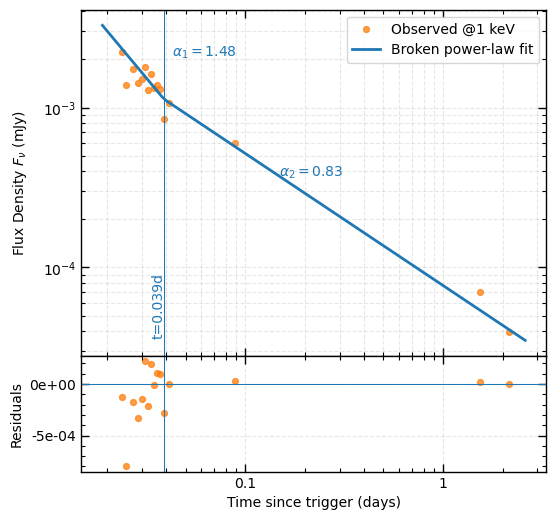

In [323]:
x=data2["Times"]/86400 
y1=data2["F_E1_mJy"]

result1, popt1, pcov1 = fit_sbpl_sharp(x[4:], y1[4:], yerr=None)
plot_sbpl_fit_with_break(x, y1, popt=popt1, result=result1, label='@1 keV', yerr=None, save_fig_file='plots/powerlaw-xray-1keV.png')


residuals=[-6.00747027e-05 -1.53162362e-04 -2.61287384e-06 -1.65141222e-05
 -4.83888762e-06  1.63118115e-05 -1.51142206e-05  5.78555187e-06
 -1.60044839e-05 -2.10813870e-06  7.59113783e-06 -1.10751092e-05
  1.50462271e-05  4.35231546e-06 -3.13747599e-06 -4.88813151e-06]
x_fit=[0.01899914 0.01996705 0.02098427 0.02205331 0.02317681]..


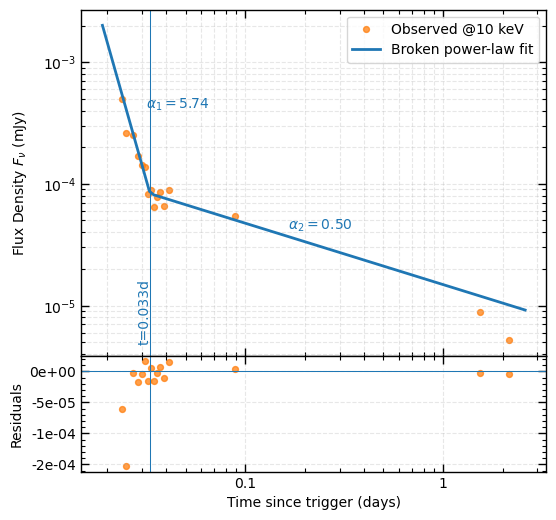

In [324]:
x=data2["Times"]/86400 
y1=data2["F_E10_mJy"]

result1, popt1, pcov1 = fit_sbpl_sharp(x[4:], y1[4:], yerr=None)
plot_sbpl_fit_with_break(x, y1, popt=popt1, result=result1, label='@10 keV', yerr=None, save_fig_file='plots/powerlaw-xray-10keV.png')


## Single power-law fit runs


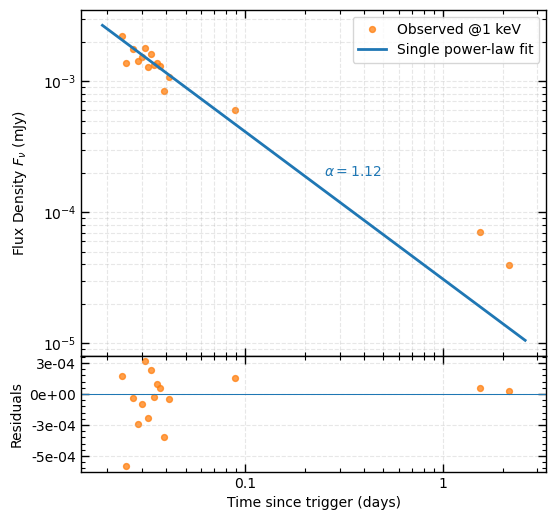

In [325]:
# 1 keV single power-law fit
x = data2["Times"]/86400
y_1keV = data2["F_E1_mJy"]

res_1, popt_1, pcov_1 = fit_spl(x[4:], y_1keV[4:], yerr=None)
plot_spl_fit(x, y_1keV, popt=popt_1, result=res_1, label='@1 keV', yerr=None,
             save_fig_file='plots/powerlaw-xray-1keV-spl.png')


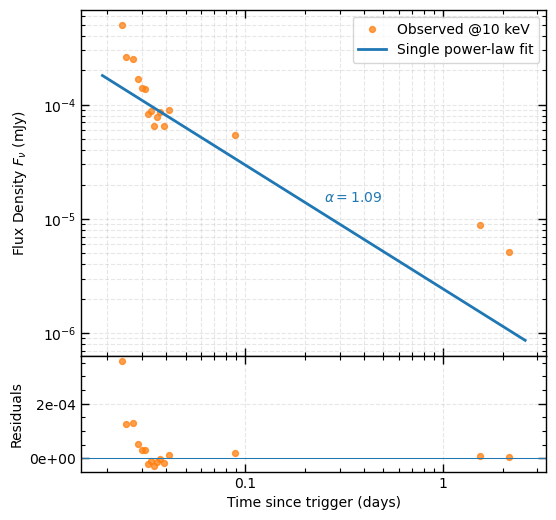

In [326]:
# 10 keV single power-law fit
x = data2["Times"]/86400
y_10keV = data2["F_E10_mJy"]

res_10, popt_10, pcov_10 = fit_spl(x[4:], y_10keV[4:], yerr=None)
plot_spl_fit(x, y_10keV, popt=popt_10, result=res_10, label='@10 keV', yerr=None,
             save_fig_file='plots/powerlaw-xray-10keV-spl.png')
